Se deben generar 5 robots como Roombas, que limpien una oficina y cada una tiene capacidad de 5 unidades de basura. Al inicio, se debe ingresar un .txt con las dimensiones de la sala (5<=x<=50) y después se dará el mapeo, EJ:


4 4  
S 0 X 3  
1 2 7 X  
2 X 2 2  
0 0 0 P  


6 5  
S 4 0 6 0   
6 X 0 X 4  
0 X 7 X 0  
5 0 0 X 8  
0 0 X 0 0  
0 0 0 0 P  

Los espacios en los que hay una X, son espacios inaccesibles, P es la papelera y S es el punto de partida de los robots. Los robots no pueden conocer el mapa, solo pueden conocer la ubicación de la papelera. Los robots deberán explorar y recoger las unidades de basura que puedan, en caso de requerir ayuda, pueden solicitar ayuda a los demás robots. Cabe destacar que los robots no pueden saber nada del mapa a excepción de lo que se mapea, en caso de que los robots muestren que saben donde hay basura, se penalizarán por 50 puntos.

Los robots son capaces de ver y dar a conocer a los demás robots solo los bloques con los que estén colindando. Solo puede saber a su alrededor si hay obstáculos, otro robot o basura, más no puede saber cuanta basura hay hasta que está en ese espacio.   
EJ:

? ? ? ? ? ? ? ?  
? ? ? B B B ? ?  
? ? ? B R B ? ?  
? ? ? B B X ? ?  
? ? ? ? ? ? ? ?  



Si tienes alguna duda, habla con el profesor o revisa el repo de la clase.


In [24]:
# PARA COLAB SOLAMENTE O ENTORNOS EXTERNOS
# !pip install mesa scikit-learn numpy pandas matplotlib networkx

In [25]:
# Imports
from mesa import Agent, Model
from mesa.time import RandomActivation
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import heapq
import random
%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128
import pandas as pd
from mesa.datacollection import DataCollector
from IPython.display import HTML
import heapq
import numpy as np
import networkx as nx

In [26]:
def leer_mapa(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
        mapa = [list(line.replace(" ", "").strip()) for line in lines[1:]]

    filas = len(mapa)
    columnas = len(mapa[0])

    for i in range(filas):
        for j in range(columnas):
            if mapa[i][j] not in ['S', 'P']:
                mapa[i][j] = '?'

    print("Mapa leído:")
    for fila in mapa:
        print(' '.join(fila))
        
    return mapa

#########################################################
# Se comentaron todolo relacionado al grafo para tratar #
# de buscar una solución donde los robots no sepan el   # 
# mapa. Trataré de hacer que 1 robot se rife a explorar #
# todo el mapa y haga el mapeo correspondiente.         #
#########################################################

# def construir_grafo(mapa):
#    grafo = {}
#    filas = len(mapa)
#    columnas = len(mapa[0])
#
#    for i in range(filas):
#        for j in range(columnas):
#            if mapa[i][j] != 'X':
#                nodo = (i, j)
#                vecinos = []
#
#                if i - 1 >= 0 and mapa[i-1][j] != 'X': vecinos.append((i-1, j))
#                if i + 1 < filas and mapa[i+1][j] != 'X': vecinos.append((i+1, j))
#                if j - 1 >= 0 and mapa[i][j-1] != 'X': vecinos.append((i, j-1))
#                if j + 1 < columnas and mapa[i][j+1] != 'X': vecinos.append((i, j+1))
#
#                grafo[nodo] = vecinos
#                
#    
#        # Vamos a dibujar el grafo para entenderlo:
#
#    G = nx.DiGraph()
#
#    # Agrega los nodos al grafo
#    for nodo, vecinos in grafo.items():
#        G.add_node(nodo)
#        for vecino in vecinos:
#            G.add_edge(nodo, vecino)
#            
#    # Se espejea el dibujo para que Rodri no me esté molestando
#    pos = {nodo: (x, -y) for nodo, (x, y) in nx.spring_layout(G).items()}
#    
#    # Dibuja el grafo utilizando matplotlib
#    pos = {nodo: nodo for nodo in G.nodes()}  # Definir la posición de los nodos para que se dibujen en sus coordenadas
#    nx.draw(G, pos, with_labels=True, node_size=1000, font_size=10, node_color='lightblue', font_color='black')
#
#    # Rotar el gráfico
#    plt.xticks(rotation=90)  # Cambia el ángulo de las etiquetas del eje x (en grados)
#
#    # Iguala el aspecto del gráfico para que las proporciones no se distorsionen
#    plt.gca().set_aspect('equal')
#
#    # Muestra el dibujo del grafo
#    plt.show()
#
#    return grafo

In [27]:
# Se definen algoritmos

#########################################################
# Se comentaron todos los algoritmos para tratar de     #
# buscar una solución donde los robots no sepan el mapa # 
# trataré de hacer que 1 robot se rife a explorar todo  #
# el mapa y haga el mapeo correspondiente.              #
#########################################################

# def heuristic(a, b):
#    return abs(a[0] - b[0]) + abs(a[1] - b[1])

# Implementación del algoritmo A*
# def a_star_search(graph, start, goal):
#    frontier = []
#    heapq.heappush(frontier, (0, start))
#    came_from = {}
#    cost_so_far = {}
#    came_from[start] = None
#    cost_so_far[start] = 0

#    while frontier:
#        _, current = heapq.heappop(frontier)

#        if current == goal:
#            break

#        for next in graph[current]:
#            new_cost = cost_so_far[current] + 1
#            if next not in cost_so_far or new_cost < cost_so_far[next]:
#                cost_so_far[next] = new_cost
#                priority = new_cost + heuristic(goal, next)
#                heapq.heappush(frontier, (priority, next))
#                came_from[next] = current
# 
#    Reconstruct path
#    current = goal
#    path = []
#    while current != start:
#        path.append(current)
#        current = came_from[current]
#    path.append(start)
#    path.reverse()
#    return path

In [28]:
# Definición de Agentes

# El agente si lo modificaré más de la cuenta, me refiero a que no comentaré lo que no sirva,
# directamente lo borraré para hacer más limpia esta sección.

class Robot(Agent):
    def __init__(self, unique_id, model, inicio):
        super().__init__(unique_id, model)
        self.posicion = inicio
        self.capacidad = 5
        self.memoria = {}
        self.basura_no_recogida = None

    def step(self):
        self.mapeo()
        self.moverse()
        self.comunicarse()
        
    def mapeo(self):
        # Se supone que los robots no conocen el mapa, solo su posición inicial y donde está el bote de basura
        self.memoria[self.posicion] = 'robot'
        self.memoria[self.model.bote_basura] = 'bote_basura'
        self.memoria[self.model.basura] = 'basura'
        self.memoria[self.obstaculo] = 'obstaculo'
        
    def moverse(self):
        possible_moves = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        new_position = random.choice(possible_moves)
        self.model.grid.move_agent(self, new_position)
    
#        # Moverse hacia la basura más cercana
#        if len(camino_corto) > 1:
#            nueva_posicion = camino_corto[1]
#            self.posicion = nueva_posicion
#
#            # Recoger basura
#            if mapa[nueva_posicion[0]][nueva_posicion[1]].isdigit() and int(mapa[nueva_posicion[0]][nueva_posicion[1]]) > 0:
#                basura = min(int(mapa[nueva_posicion[0]][nueva_posicion[1]]), self.capacidad)
#                self.capacidad -= basura
#                mapa[nueva_posicion[0]][nueva_posicion[1]] = str(int(mapa[nueva_posicion[0]][nueva_posicion[1]]) - basura)
#
#                # Si no pudo recoger toda la basura, almacena la posición
#                if int(mapa[nueva_posicion[0]][nueva_posicion[1]]) > 0:
#                    self.basura_no_recogida = nueva_posicion
#
#        # Comunicación entre robots
#        for agent in self.model.schedule.agents:
#            if isinstance(agent, Robot) and agent != self:
#                self.memoria.update(agent.memoria)
#                agent.memoria.update(self.memoria)
#
#                # Comparte la posición de basura no recogida
#                if self.basura_no_recogida:
#                    agent.memoria[self.basura_no_recogida] = 'basura_no_recogida'

In [29]:
# Se define el modelo

class LimpiezaModel(Model):
    def __init__(self, mapa_txt):
        self.num_robots = 5
        self.schedule = RandomActivation(self)
        self.mapa = leer_mapa(mapa_txt)
#        self.grafo = construir_grafo(self.mapa)

        self.fig, self.ax = plt.subplots()

        # Creación de robots
        for i in range(self.num_robots):
            robot = Robot(i, self, (0, 0))
            self.schedule.add(robot)

    def draw_map(self):
        self.ax.clear()
        for i, row in enumerate(self.mapa):
            for j, cell in enumerate(row):
                if cell == 'X':
                    self.ax.text(j, i, cell, ha='center', va='center', fontsize=60, color='black')
                elif cell in ['S', 'P']:
                    self.ax.text(j, i, cell, ha='center', va='center', fontsize=60, color='blue')
                else:
                    self.ax.text(j, i, '?', ha='center', va='center', fontsize=60, color='blue')
        for agent in self.schedule.agents:
            self.ax.text(agent.posicion[1], agent.posicion[0], 'R', ha='center', va='center', fontsize=40, color='red')
            
    def step(self):
        self.schedule.step()
        self.draw_map()

Mapa leído:
S ? ? ? ?
? ? ? ? ?
? ? ? ? ?
? ? ? ? ?
? ? ? ? ?
? ? ? ? P


AttributeError: 'LimpiezaModel' object has no attribute 'bote_basura'

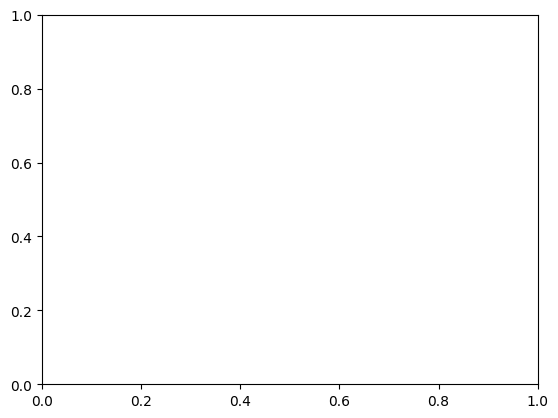

In [30]:
model = LimpiezaModel('mapa.txt')   

for i in range(10):
    model.step()


In [31]:
def main():
# Comentaré todo este código ya que imprime una gráfica vacía    
    # model = LimpiezaModel('mapa.txt')
    # ani = animation.FuncAnimation(model.fig, model.step, frames=50)
    # plt.show()

    # Para mostrar la animación como HTML
    # html = HTML(ani.to_jshtml())
    # display(html)

# if __name__ == "__main__":
    # main()

    # Por alguna razón, aunque el main esté comentado se ejecuta, por eso este pass@
    pass